In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from gym_trading_env.downloader import download

import datetime

import gymnasium as gym
import gym_trading_env

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    FeatureEngineering
)
from gym_trading_env.environments import (
    dynamic_feature_last_position_taken,
    dynamic_feature_real_position  # you can import it if you ever need it
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

BTC/USDT downloaded from binance and stored at data/binance-BTCUSDT-1d.pkl


<Axes: xlabel='date_open'>

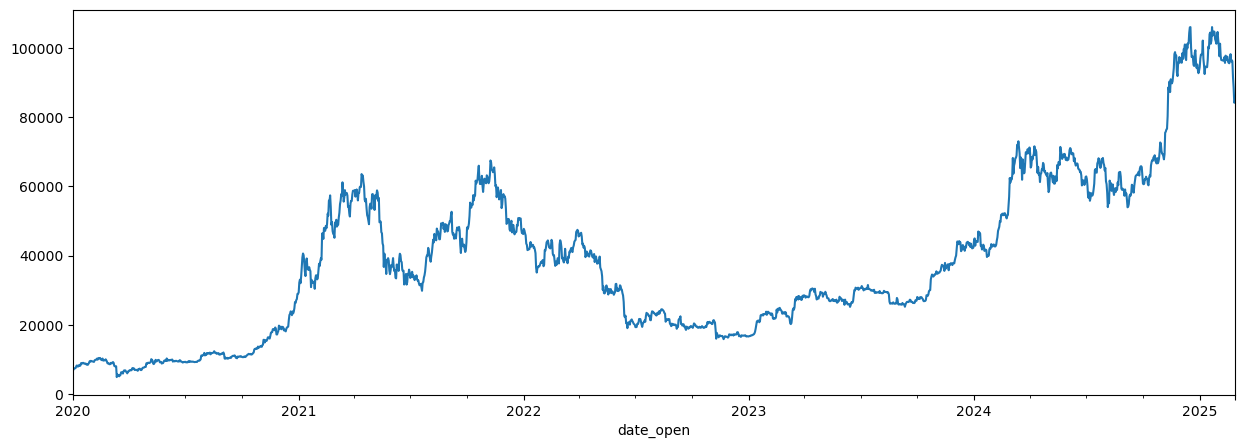

In [2]:
# Download BTC/USDT historical data from Binance and stores it to directory ./data/binance-BTCUSDT-1h.pkl
download(exchange_names = ["binance"],
    symbols= ["BTC/USDT"],
    timeframe= "1d",
    dir = "data",
    since= datetime.datetime(year= 2019, month= 12, day=31),
    until= datetime.datetime(year= 2025, month= 3, day=1)
)
# Import your fresh data
df = pd.read_pickle("./data/binance-BTCUSDT-1d.pkl")
df["close"].plot(figsize=(15, 5))

In [3]:
# Create 3-row subplot layout
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.5, 0.25, 0.25],
    subplot_titles=("BTC/USDT Candlestick", "Volume", "Daily Return (%)")
)

# Row 1: Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df["open"],
    high=df["high"],
    low=df["low"],
    close=df["close"],
    name="Price"
), row=1, col=1)

# Row 2: Volume (bar)
fig.add_trace(go.Bar(
    x=df.index,
    y=df["volume"],
    marker_color='gray',
    name="Volume"
), row=2, col=1)

daily_ret = df["close"].pct_change()
# Row 3: Daily Return (bar or line, here we use bar)
fig.add_trace(go.Bar(
    x=df.index,
    y=daily_ret,
    marker_color=daily_ret.apply(lambda x: 'green' if x >= 0 else 'red'),
    name="Daily Return"
), row=3, col=1)

# Layout tweaks
fig.update_layout(
    title="BTC/USDT Candlestick with Volume and Daily Return",
    xaxis_rangeslider_visible=False,
    height=900,
    showlegend=False,
    margin=dict(t=50, b=40)
)

fig.update_yaxes(title_text="Price (USDT)", row=1, col=1)
fig.update_yaxes(title_text="Volume", row=2, col=1)
fig.update_yaxes(title_text="Return", row=3, col=1)

fig.show()

In [4]:
adfuller_test = adfuller(df["close"].dropna())
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -1.0825393020194665
p-value: 0.7219845664645004
Is the spread stationary? No


In [5]:
# build features
train_size = 0.8
df_train = df.copy().iloc[:int(len(df)*train_size)]
df_test = df.copy().iloc[int(len(df)*train_size):]

feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 5,  # sidetrack: the rolling window mean correction can somehow help detect mean shift
       'mode': 'diff',
     }},
]

fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)

fe = FeatureEngineering(df_test)
df_test = fe.build_features(feature_config)

In [6]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1.]
Market Return : 623.86%   |   Portfolio Return : -39.59%   |   Position Changes : 993   |   Episode Length : 1508   |   


In [7]:
# agent = DQNAgent(n_observations, n_actions, target_net_layers=[32], policy_net_layers=[32])
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20)

Market Return : 623.86%   |   Portfolio Return : -82.70%   |   Position Changes : 989   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : -60.16%   |   Position Changes : 983   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : -68.63%   |   Position Changes : 980   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : 11.19%   |   Position Changes : 1012   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : 2933.71%   |   Position Changes : 1020   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : 10496.91%   |   Position Changes : 1028   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : 26988.46%   |   Position Changes : 1071   |   Episode Length : 1508   |   
Market Return : 623.86%   |   Portfolio Return : 10377.27%   |   Position Changes : 1072   |   Episode Length : 1508   |   
Market Return : 623.8

In [8]:
def extract_signals(historical_info_df: pd.DataFrame):
    """
    Given a DataFrame with columns ['data_close', 'position'], 
    shift and detect only the entry/exit transitions.
    Returns (buy_df, sell_df, exit_df).
    """
    df = historical_info_df[['data_close', 'position']].copy()
    df['position'] = df['position'].shift(-1)
    df['prev_position'] = df['position'].shift(1)

    buy_df = df[(df['position'] == 1) & (df['prev_position'] != 1)]
    sell_df = df[(df['position'] == -1) & (df['prev_position'] != -1)]
    exit_df = df[(df['position'] == 0) & (df['prev_position'] != 0)]

    return buy_df, sell_df, exit_df


def build_fig(historical_info_df: pd.DataFrame,
              buy_df: pd.DataFrame,
              sell_df: pd.DataFrame,
              exit_df: pd.DataFrame):
    """
    Build a 2-row subplot:
     - Row 1: candlestick + buy/sell/exit markers
     - Row 2: portfolio valuation line
    Returns the Plotly Figure.
    """
    sample = historical_info_df
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.7, 0.3],
        subplot_titles=["Price Candlestick", "Portfolio Value"]
    )

    # Row 1: Candlestick
    fig.add_trace(go.Candlestick(
        x=sample.index,
        open=sample['data_open'],
        high=sample['data_high'],
        low=sample['data_low'],
        close=sample['data_close'],
        name="Price"
    ), row=1, col=1)

    # Markers
    marker_specs = {
        'Buy':    dict(df=buy_df,   color='green', symbol='triangle-up'),
        'Sell':   dict(df=sell_df,  color='red',   symbol='triangle-down'),
        'Exit':   dict(df=exit_df,  color='blue',  symbol='circle'),
    }
    for name, spec in marker_specs.items():
        fig.add_trace(go.Scatter(
            x=spec['df'].index,
            y=spec['df']['data_close'],
            mode='markers',
            marker=dict(color=spec['color'], size=10, symbol=spec['symbol']),
            name=name
        ), row=1, col=1)

    # Row 2: Portfolio value
    fig.add_trace(go.Scatter(
        x=sample.index,
        y=sample['portfolio_valuation'],
        mode='lines',
        line=dict(color='blue'),
        name="Portfolio Value"
    ), row=2, col=1)

    # Layout
    fig.update_layout(
        height=500,
        margin=dict(t=40, b=20, l=40, r=20),
        xaxis_rangeslider_visible=False,
        xaxis2_rangeslider_visible=False  # if you ever disable or have more subplots
    )
    return fig

In [9]:
env_test = gym.make("TradingEnv",
        name= "stationaryDGP",
        df = df_test, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
    )
env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

env_test = agent.eval(env_test)

Market Return : 63.33%   |   Portfolio Return : 126.94%   |   Position Changes : 260   |   Episode Length : 378   |   


In [10]:
historical_info_df = pd.DataFrame(list(env_test.unwrapped.historical_info))

buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()